In [ ]:
!pip install xgboost scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00a 0:00:01


## Import packages and Data

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [14]:
# Load the data
df = pd.read_csv('data/df_rolling_window_imputation.csv', index_col=['id', 'time'])
df

,,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,call,circumplex.arousal,circumplex.valence,mood,screen,sms
id,time,,,,,,,,,,,,
AS14.01,2014-03-14,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
AS14.02,2014-03-14,NaN,7.521571,16.532758,16.045800,24.787444,5.726200,1.0,NaN,NaN,NaN,21.988562,1.0
AS14.03,2014-03-14,NaN,7.521571,16.532758,16.045800,24.787444,5.726200,1.0,NaN,NaN,NaN,21.988562,1.0
AS14.05,2014-03-14,NaN,15.121824,49.573057,4.144754,44.801875,58.581125,1.0,-1.0,2.0,8.0,63.892159,1.0
AS14.08,2014-03-14,NaN,20.439069,15.310760,10.095277,8.451600,30.768107,1.0,-0.2,1.2,7.4,71.859192,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AS14.26,2014-05-15,0.141308,9.825879,67.822636,62.043000,5.873400,67.472417,1.0,0.2,0.2,6.4,167.927026,1.0
AS14.27,2014-05-15,0.091036,20.875250,102.692800,73.662050,11.396467,105.163411,1.0,1.5,0.5,7.0,193.589309,1.0
AS14.29,2014-05-15,0.066597,9.856749,74.322233,99.372375,11.396467,105.163411,1.0,-0.5,0.0,6.0,179.972857,1.0


## Prepare Data for Feature Selection

In [4]:
df.reset_index(level='time', inplace=True)
df['time'] = pd.to_datetime(df['time'])
df = df.fillna(df.mean()) # Replace NaNs with mean of column

# Shift the 'mood' column up to represent the next day's mood
df['mood_next_day'] = df.groupby(level=0)['mood'].shift(-1)

df.drop(['mood'], axis=1, inplace=True)
# Drop the last row for each id where the next day's mood would be NaN
df.dropna(subset=['mood_next_day'], inplace=True)

# Split into X and y
X = df.drop(['mood_next_day'], axis=1)
y = df['mood_next_day']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.drop('time', axis=1)
X_test = X_test.drop('time', axis=1)

In [8]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

model.fit(X_train, y_train)

# Optionally, evaluate the model on the test set
# predictions = model.predict(X_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

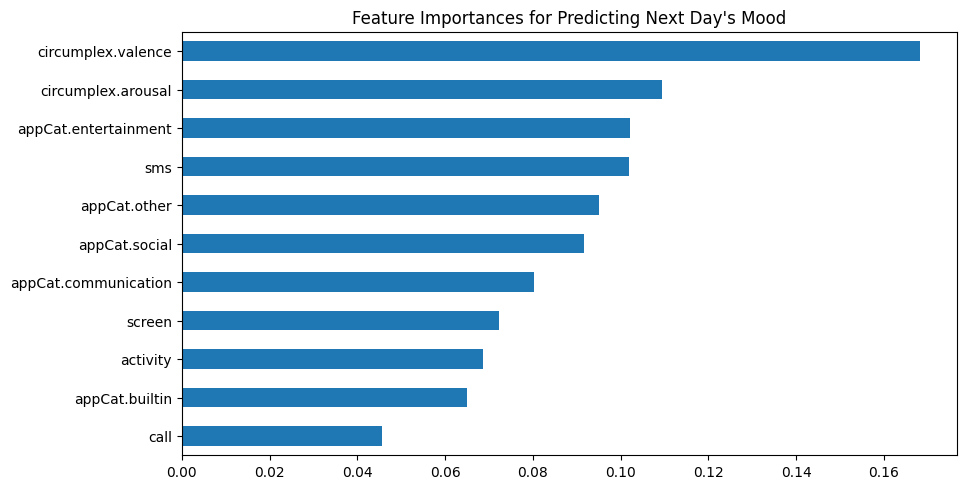

In [11]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort the feature importances in ascending order for better visualization
sorted_importances = feature_importances.sort_values()

# Plot all feature importances
sorted_importances.plot(kind='barh', figsize=(10, len(sorted_importances)/2))  # Adjust the figure height dynamically based on the number of features

plt.title('Feature Importances for Predicting Next Day\'s Mood')
plt.show()
